# Statistics

In the [drawing graphs](./2-drawing-graphs.ipynb) notebook, when plotting record start and end dates for different ships, the records started to show clusters around times when the Royal Navy used a ship name. This notebook explores that further as a starting point to show how statistics can be used to explore data.

In [39]:
%pip install -q scikit-learn
%pip install -q csv
%pip install -q matplotlib
%pip install -q numpy
%pip install -q scipy
%pip install -q pandas

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from scipy import stats

import pandas

import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys 
sys.path.append('..')
from helperFunctions import helper_functions as hf


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to us

## Data

This notebook will use a couple of different data sources: the csv used in the previous two notebooks in this series, and the hypothetical ship-chase data also in use in the [mapping](../mapping/README.md) series of notebooks. 

In [40]:
ship_record_data = pandas.read_csv('ship_data.csv', sep=',', header=0)
ship_record_dataframe = pandas.DataFrame(ship_record_data)

lead_ship_data = pandas.DataFrame(hf.leader_waypoints)
chase_ship_data = pandas.DataFrame(hf.chaser_waypoints)

A few modifications to the data are needed, as most statistical analysis only work with data in the form of numbers. For both data sets, this means converting date-time data to unix time: in the data, dates are stored as full dates, unix time stores the date as a single number, the number of milliseconds before or after 1 January 1970. For the csv data, this also means dropping some of the columns (as they are not needed), and removing the 'ADM' from the reference number.

In [41]:
## Adjusting the dataset containing metadata about all the ships

ship_numberic_data = ship_record_dataframe[['startDate', 'endDate', 'record_duration', 'reference', 'description_length', 'ship']]

ship_numberic_data['reference'] = ship_record_dataframe['reference'].str.split(' ').str[1]
ship_numberic_data['reference'] = pandas.to_numeric(ship_numberic_data['reference'].str.split('/').str[0])

ship_numberic_data['startDate'] = pandas.to_datetime(ship_numberic_data['startDate']).values.astype(float)
ship_numberic_data['endDate'] = pandas.to_datetime(ship_numberic_data['endDate']).values.astype(float)

durations = []
for duration in ship_numberic_data['record_duration']:
    str(durations.append(duration.split(' ')[0]))

ship_numberic_data['record_duration'] = durations

## Adjusting the dataset containing metadata about the lead and chase ships

lead_ship_numberic = lead_ship_data
chase_ship_numberic = chase_ship_data

lead_ship_numberic['timestamp'] = pandas.to_datetime(lead_ship_numberic['timestamp']).values.astype(float)

chase_ship_numberic['timestamp'] = pandas.to_datetime(chase_ship_numberic['timestamp']).values.astype(float)

## Printing the first 5 rows of the datasets to ensure that the data has been adjusted correctly

print(ship_numberic_data.head())
print(lead_ship_numberic.head())
print(chase_ship_numberic.head())

      startDate       endDate record_duration  reference  description_length  \
0 -1.620000e+18 -1.614816e+18              60         53                   7   
1 -1.732406e+18 -1.727222e+18              60         53                   7   
2 -1.646266e+18 -1.638230e+18              93         53                   7   
3 -1.662163e+18 -1.656893e+18              61         53                   7   
4 -1.780445e+18 -1.775261e+18              60         53                   7   

     ship  
0  Acasta  
1  Acasta  
2  Acasta  
3  Acasta  
4  Acasta  
      timestamp  latitude  longitude  crew  speed
0  1.424736e+18      48.0       -7.0   223   13.0
1  1.424740e+18      48.5       -6.0   215   12.7
2  1.424743e+18      49.0       -4.5   210   13.2
3  1.424747e+18      49.5       -3.2   210   12.1
4  1.424750e+18      50.0       -2.8   198   12.3
      timestamp  latitude  longitude  crew  speed
0  1.424743e+18      47.8       -7.0   250   13.5
1  1.424747e+18      48.6       -6.3   248   12

/tmp/ipykernel_30274/1148863630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ship_numberic_data['reference'] = ship_record_dataframe['reference'].str.split(' ').str[1]
/tmp/ipykernel_30274/1148863630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ship_numberic_data['reference'] = pandas.to_numeric(ship_numberic_data['reference'].str.split('/').str[0])
/tmp/ipykernel_30274/1148863630.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

For convenience, a subset of the data (in this case, records to do with "Boxer") is isolated and made available. This smaller dataset will make it easier to read some of the example graphs and tables.

In [42]:
boxer_data = ship_numberic_data[ship_numberic_data['ship'] == 'Boxer']
boxer_data = boxer_data.drop(columns=['ship'])
print(boxer_data.head())

        startDate       endDate record_duration  reference  description_length
190 -3.355258e+18 -3.328992e+18             304         53                   6
191 -5.892480e+17 -5.866560e+17              30         53                   6
192 -5.076000e+17 -5.050080e+17              30         53                   6
193 -5.128704e+17 -5.102784e+17              30         53                   6
194 -5.286816e+17 -5.261760e+17              29         53                   6


## Dendrogram/Hierarchical Clustering

To investigate whether the records are actually forming clusters, we can use a hierarchical clustering approach, and plot the result on a dendrogram. 

This analysis looks at the data it is given, and groups similar items together. For example, if two records start at 1850 and 1851, and a third in 1920, the first two will be grouped together while the third will remain separate. Rather than just one column, all data for all items are compared. Once the data are grouped, the analysis is re-run allowing more variety within a group (for example, grouping an 1850 and 1865 record together, but sill keeping the 1920 record separate). This process is repeated until all the data are grouped together. 

The results are then plotted on a dendrogram, shown in the next cell. In this example, the `ward` distance calculation method is used, which attempts to minimise the variance of clusters being joined. Dendrograms should be read similarly to family trees; the individual records are shown on the x axis at the bottom of the graph, with the branches representing the different clusters. The longer the branch, the more statistically significant the cluster. In this dendrogram, the number at the bottom corresponds to the records row in the dataframe. 

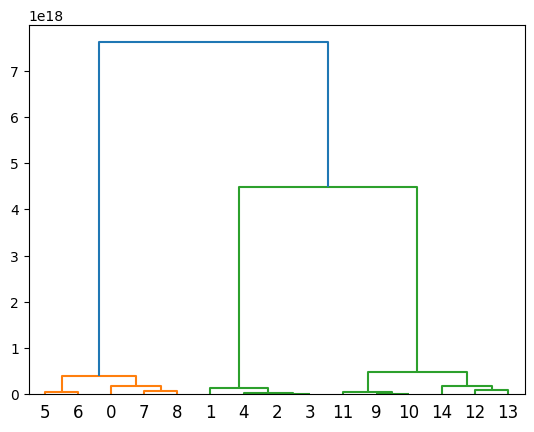

In [43]:
plt_dendro, ax_dendro = plt.subplots()
dendrogram = sch.dendrogram(sch.linkage(boxer_data, method='ward'))
plt.show()

Working up from the base of the dendrogram, we can see that the individual records quickly cluster into three distinct clusters, matching the expected result. The top half of the graph shows there may be just two clusters, which should be kept in consideration. 

## Using these clusters

Information about the number of clusters allows further analysis and visualisation of the clusters. 

The first step is assign each record to a cluster. The [`fcluster`](https://pythonguides.com/python-scipy-fcluster/) method from scipy uses the same hierarchical clustering method from the dendrogram, but here, the number of clusters is pre-specified. The output is a list, with the cluster number for each record, in order. 

In [44]:
wardlabel = fcluster(sch.linkage(boxer_data, method='ward'), 3, criterion='maxclust')

print(wardlabel)

[1 2 2 2 2 1 1 1 1 3 3 3 3 3 3]


We can then use this list of cluster numbers to colour records in scatter plots, for example. Here, we are drawing a pair, both with start date on the x-axis, one plotted against end date, and the other against duration. 

/tmp/ipykernel_30274/3064562691.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cluster_scatter_1.set_xticklabels(pandas.to_datetime(ax_cluster_scatter_1.get_xticks()).strftime('%Y-%m-%d'))  # <- this line converts the x-axis ticks from unix time to human readable time for plotting
/tmp/ipykernel_30274/3064562691.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cluster_scatter_1.set_yticklabels(pandas.to_datetime(ax_cluster_scatter_1.get_yticks()).strftime('%Y-%m-%d'))
/tmp/ipykernel_30274/3064562691.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_cluster_scatter_2.set_xticklabels(pandas.to_datetime(ax_cluster_scatter_2.get_xticks()).strftime('%Y-%m-%d'))


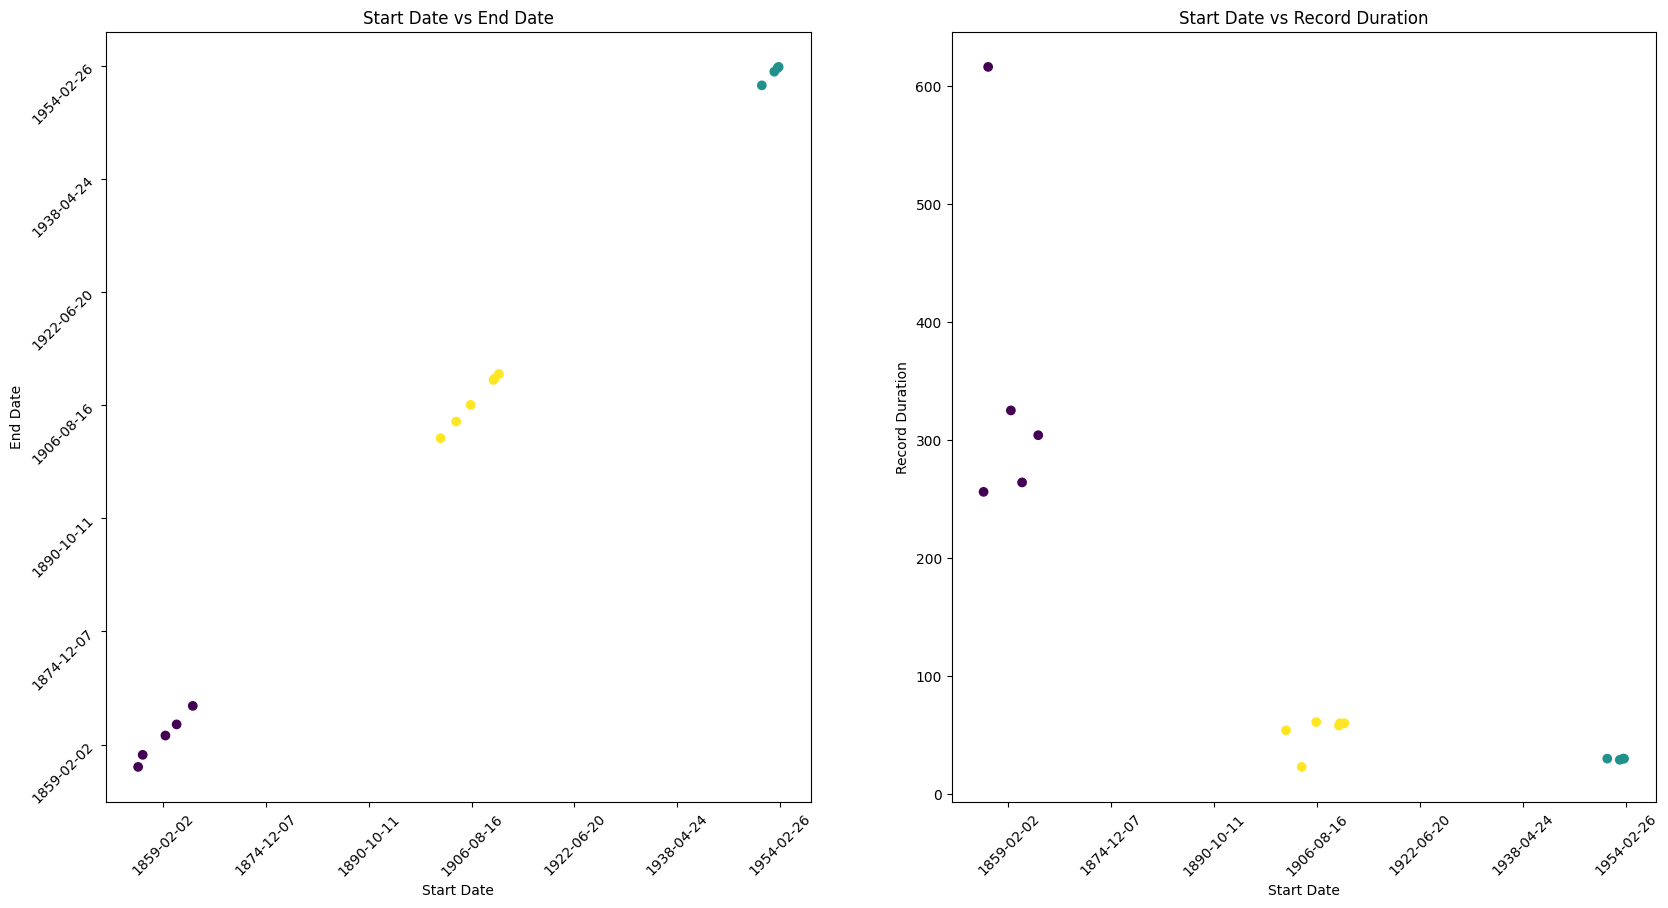

In [45]:
fig_cluster_scatter, (ax_cluster_scatter_1, ax_cluster_scatter_2) = plt.subplots(1, 2, figsize=(20, 10))

ax_cluster_scatter_1.scatter(boxer_data['startDate'], boxer_data['endDate'], c=wardlabel, cmap='viridis')
ax_cluster_scatter_1.set_xlabel('Start Date')
ax_cluster_scatter_1.set_xticklabels(pandas.to_datetime(ax_cluster_scatter_1.get_xticks()).strftime('%Y-%m-%d'))  # <- this line converts the x-axis ticks from unix time to human readable time for plotting
ax_cluster_scatter_1.tick_params(axis='x', rotation=45)
ax_cluster_scatter_1.set_ylabel('End Date')
ax_cluster_scatter_1.set_yticklabels(pandas.to_datetime(ax_cluster_scatter_1.get_yticks()).strftime('%Y-%m-%d'))
ax_cluster_scatter_1.tick_params(axis='y', rotation=45)
ax_cluster_scatter_1.set_title('Start Date vs End Date')

ax_cluster_scatter_2.scatter(boxer_data['startDate'], [float (i) for i in boxer_data['record_duration']], c=wardlabel, cmap='viridis') # <- the 'record_duration' column is a string, so converting it to a float means its
                                                                                                                                       # plotted in the correct order
ax_cluster_scatter_2.set_xlabel('Start Date')
ax_cluster_scatter_2.set_xticklabels(pandas.to_datetime(ax_cluster_scatter_2.get_xticks()).strftime('%Y-%m-%d'))
ax_cluster_scatter_2.tick_params(axis='x', rotation=45)
ax_cluster_scatter_2.set_ylabel('Record Duration')
ax_cluster_scatter_2.set_title('Start Date vs Record Duration')
plt.show()

Even without colouring the points, three clusters are clearly visible - matching the expected outcome from the dendrogram, and knowledge about the original data. Consider, however, if the Royal Navy had used the name 'Boxer' four times in the time period; you would expect four clusters. Try changing the number of clusters in the wardlabel cell to four, and re-run both it and the plotting cell. Or, consider the dendrogram that indicated there might be just two clusters, and do the same. In both cases, you should see that the points do not move, indicating three clusters; you should also see that the colouration does change, showing both the location of the new definition of the clusters, and how colouring the points in a scatter graph can highlight underlying structure.

Compare the start date vs duration graph to the bar graph of record start and end dates from the previous notebook. The two graphs are showing effectively the same information (record start date and relative duration), but in two different ways - for example, the shorter duration records in the bar graph may become harder to see, but the bar graph may highlight the difference in duration more clearly. When graphing data, consider the best way to show the important information.

## Linear regression

It can often appear as if one change correlates to another in a dataset - for example, an increase in wealth may look like it predicts that life expectancy will increase. A linear regression is a way to test this and determines how closely a straight line matches the data. 

This test provides you with a value for the slope of the line, and the y-intercept (where the line meets the y-axis), giving enough information to plot the line and establish how strongly the cause changes the effect (for example, how much greater gdp changes a countries life expectancy). It also provides an r- and a p- value.  The p-value represents the probability that the slope of the line is 0. The r-value is the Pearson correlation coefficient, which, when squared, becomes the coefficient of determination. This value is particularly important, representing the proportion of the variance in the dependent variable that is predictable from the independent variable; testing to see if the line actually fits the data, and whether the independent variable is a good predictor of the dependent variable.

This test is available via SciPy, and compares two lists of equal length. As the data from the lead and chase ships are both recorded in 1-hour steps, and both have longitude data, we can run the comparison on both ships.

Lead Ship Regression:  LinregressResult(slope=-3.342592592592592e-13, intercept=476246.30222222215, rvalue=-0.8054839092025372, pvalue=0.008785414793724107, stderr=9.295058659719246e-14, intercept_stderr=132431.38543740296)
Chase Ship Regression:  LinregressResult(slope=-2.083333333333335e-14, intercept=29695.0277777778, rvalue=-0.27399661915064094, pvalue=0.47557037306336725, stderr=2.7638724559997626e-14, intercept_stderr=39378.4828720013)
Lead Ship R^2:  0.6488043279842012
Chase Ship R^2:  0.07507414730598137


/tmp/ipykernel_30274/2211395454.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_regressions_lead.set_xticklabels(pandas.to_datetime(ax_regressions_lead.get_xticks()).strftime('%Y-%m-%d'))
/tmp/ipykernel_30274/2211395454.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_regressions_chase.set_xticklabels(pandas.to_datetime(ax_regressions_chase.get_xticks()).strftime('%Y-%m-%d'))


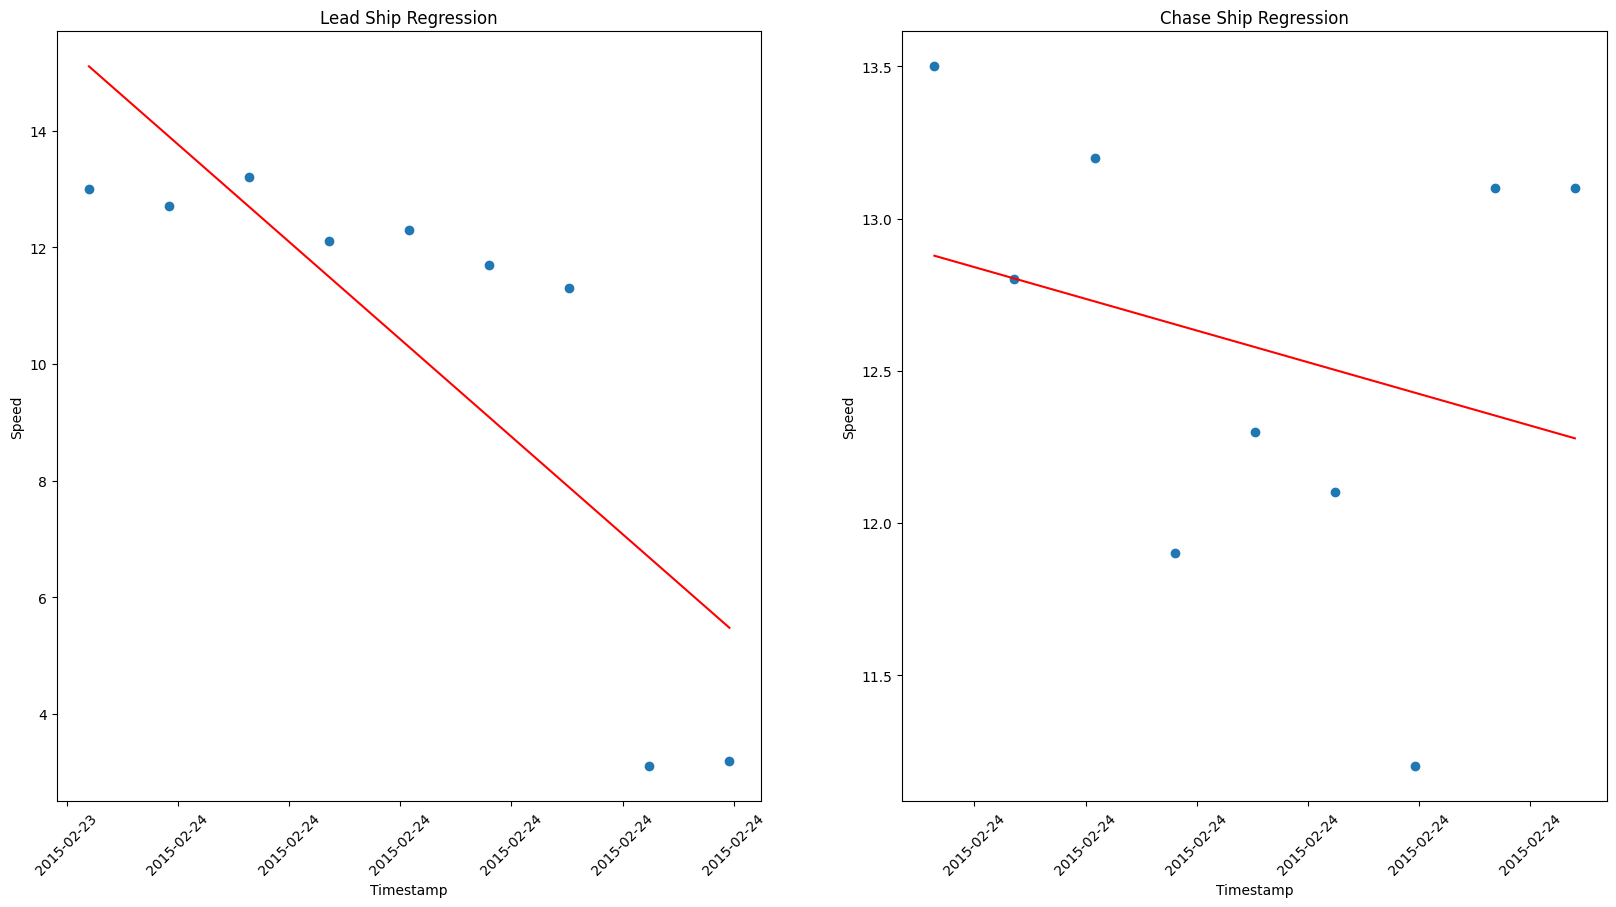

In [46]:
lead_lat = lead_ship_data['speed']
lead_timestamp = lead_ship_data['timestamp']
chase_lat = chase_ship_data['speed']
chase_timestamp = chase_ship_data['timestamp']

lead_ship_regression = stats.linregress(lead_timestamp, lead_lat)
chase_ship_regression = stats.linregress(chase_timestamp, chase_lat)

print("Lead Ship Regression: ", lead_ship_regression)
print("Chase Ship Regression: ", chase_ship_regression)
print("Lead Ship R^2: ", lead_ship_regression.rvalue**2)
print("Chase Ship R^2: ", chase_ship_regression.rvalue**2)

plt_regressions, (ax_regressions_lead, ax_regressions_chase) = plt.subplots(1, 2, figsize=(20, 10))

ax_regressions_lead.scatter(lead_timestamp, lead_lat)
line_lead = [lead_ship_regression.slope * i + lead_ship_regression.intercept for i in lead_timestamp]
ax_regressions_lead.plot(lead_timestamp, line_lead, 'r')
ax_regressions_lead.set_xlabel('Timestamp')
ax_regressions_lead.set_xticklabels(pandas.to_datetime(ax_regressions_lead.get_xticks()).strftime('%Y-%m-%d'))
ax_regressions_lead.tick_params(axis='x', rotation=45)
ax_regressions_lead.set_ylabel('Speed')
ax_regressions_lead.set_title('Lead Ship Regression')
ax_regressions_chase.scatter(chase_timestamp, chase_lat)

line_chase = [chase_ship_regression.slope * i + chase_ship_regression.intercept for i in chase_timestamp]
ax_regressions_chase.plot(chase_timestamp, line_chase, 'r')
ax_regressions_chase.set_xlabel('Timestamp')
ax_regressions_chase.set_xticklabels(pandas.to_datetime(ax_regressions_chase.get_xticks()).strftime('%Y-%m-%d'))
ax_regressions_chase.tick_params(axis='x', rotation=45)
ax_regressions_chase.set_ylabel('Speed')
ax_regressions_chase.set_title('Chase Ship Regression')

plt.show()

In both of these examples, the R squared is lower than 0.95 (or 95%), meaning that a straight line does not predict the data well. While this may initially seem unexpected, it is explainable for both ships. Looking at the lead ship, its speed drops away considerably near the end when it is dis-masted. Before this point, it was slowly dropping in speed (presumably due to less major rigging damage) and may have been on a straight line. In situations like this, the two points after the dismastment may be considered outliers, and the linear regression rerun without them. Whether or not this is appropriate depends on the context of the data. The chase ship, on the other hand, has a much lower spread of recorded speeds, but they are more varied. This is likely due to the chase ship having to vary speed to maintain the distance while also firing broadsides on the lead ship. This is reflected in the lower R squared value. 
Despite the low R squared values, there is valuable information in the linear regression. The low r-squared values lets us know that the speed for both ships changes notably over the time period, indicating other events are affecting the speed. The linear regression also provides an equation for the line - if the R squared was higher, this could be used to predict the speed at a future time. 

## All the data 

Rather than drawing lots of separate scatter plots for each combination of variables, it is possible to draw a single scatter plot of all the data at once while keeping as much of the information as possible. This is achieved through a scatter plot based on a Principal Component Analysis (PCA).

Plotting a PCA is similar to plotting a 2-d scatter plot, but taking into account multiple dimensions and keeping as much of the information as possible. Imagine a 3-d scatter plot: if the points formed a football, plotting a silhouette would look like a circle; if the points formed closer to a rugby ball shape, the points would instead look like an oval. A PCA achieves this with as many dimensions as supplied to it (with dimensions here referring to columns in the data, or variables). To make PCAs easier to read, variables from the original data can be drawn onto the scatter plot as arrows - with longer arrows generally representing a stronger effects on how the points are distributed.

The 'components' in the name of the analysis relates to these factors used to project the data. A PCA aims to reduce the number of dimensions (or columns), while keeping as much variation as possible. Thus, if two dimensions are very similar, the PCA keep them as a single component.

PCAs are another statistical tool needing numerical  data, so the unix-timestamps will again be used. As PCAs are designed to highlight the data with the most variation, the first step before running one is to normalise the data. Normalisation makes data on radically different scales comparable - the unix timestamps are on a scale of milliseconds, resulting in values around -1x10^18, while the ship crews are around 200. Normalising the data is done by subtracting the mean and dividing by the standard deviation, resulting in a mean of 0 and a standard deviation of 1. This is available through the `StandardScaler` method from the `sklearn.preprocessing` module.

In [47]:
leader_normalised = StandardScaler().fit_transform(lead_ship_numberic) # The StandardScaler tool works on all the data in a dataframe, meaning we can just pass the entire dataframe all at once
chaser_normalised = StandardScaler().fit_transform(chase_ship_numberic)

The PCA is run first, before drawing the plot. Here we are running 2 in parallel, so we can compare the lead and chase ships. Once the PCA has been run, the loadings (the arrows, and known as such as they describe how much the variable 'loads' or contributes to the component) can calculated using the information it provides.

In [48]:
pca_leader = PCA()
pca_chaser = PCA()

leader_principal_components = pca_leader.fit_transform(leader_normalised)
chaser_principal_components = pca_chaser.fit_transform(chaser_normalised)

leader_loadings = pca_leader.components_.T * np.sqrt(pca_leader.explained_variance_)
chaser_loadings = pca_chaser.components_.T * np.sqrt(pca_chaser.explained_variance_)

Plotting the PCA is then a scatter plot, following the same approach that was shown in the previous notebook. The main difference is that the loadings are drawn in as arrows on top of the points. 

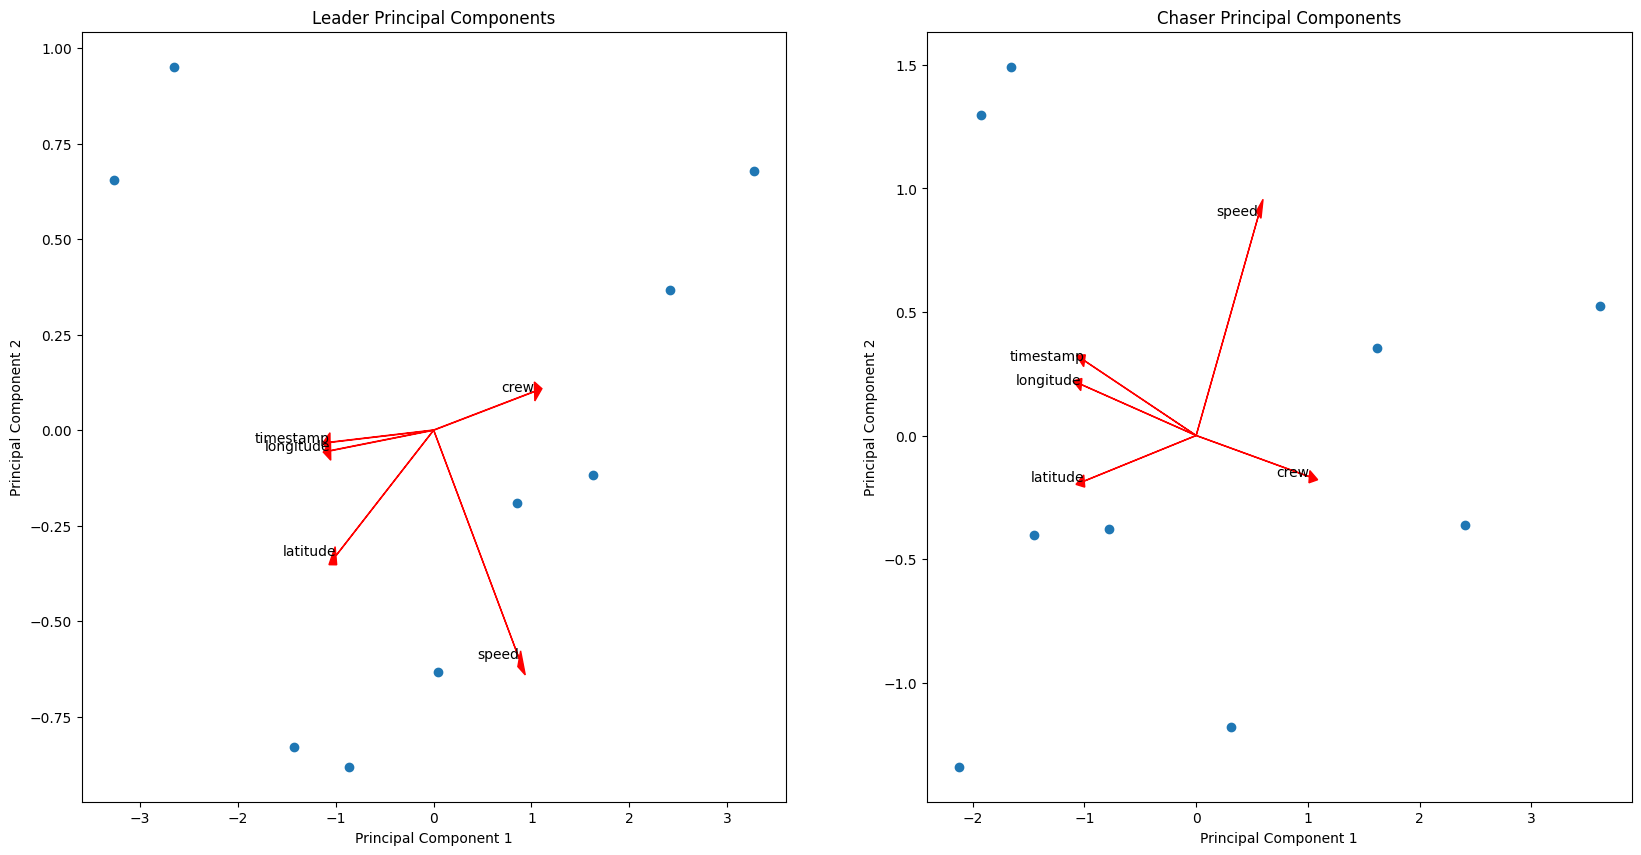

In [49]:
fig_pca_comp, (ax_pca_comp_lead, ax_pca_comp_chase) = plt.subplots(1, 2, figsize=(20, 10))

ax_pca_comp_lead.scatter(leader_principal_components[:, 0], leader_principal_components[:, 1])
for i, (x, y) in enumerate(zip(leader_loadings[:, 0], leader_loadings[:, 1])):
    ax_pca_comp_lead.arrow(0, 0, x, y, color='r', head_width=0.05)
    ax_pca_comp_lead.text(x, y, lead_ship_numberic.columns[i], fontsize='10', ha='right')

ax_pca_comp_lead.set_xlabel('Principal Component 1')
ax_pca_comp_lead.set_ylabel('Principal Component 2')
ax_pca_comp_lead.set_title('Leader Principal Components')

ax_pca_comp_chase.scatter(chaser_principal_components[:, 0], chaser_principal_components[:, 1])
for i, (x, y) in enumerate(zip(chaser_loadings[:, 0], chaser_loadings[:, 1])):
    ax_pca_comp_chase.arrow(0, 0, x, y, color='r', head_width=0.05)
    ax_pca_comp_chase.text(x, y, chase_ship_numberic.columns[i], fontsize='10', ha='right')

ax_pca_comp_chase.set_xlabel('Principal Component 1')
ax_pca_comp_chase.set_ylabel('Principal Component 2')
ax_pca_comp_chase.set_title('Chaser Principal Components')

plt.show()

The loadings on these two PCAs show some interesting results. For example, longitude and timestamp point in roughly the same direction - this suggests that time of day correlates with longitude. This is expected with this dataset; the ships are chasing up the English channel, which is east-west. In both cases, the speed of the ship is the largest loading, indicating that this is the cause of the most variation in the data. The speed loading is at approximately 90 degrees to the longitude and timestamp loadings, suggesting that it varies independently of the other two.

Different components in the PCA will have stronger or weaker effects on the outcome, and some may have so little effect that they are statistically insignificant. A scree plot shows their different levels with the components shown on the x-axis and level of effect they have on the y-axis. Note that components do not necessarily mean columns in the original database - PCAs aim to reduce the number of dimensions in the data, so two or more columns may contribute to a single component. Higher numbered components have less effect on the PCA, leading to the slope of the graph, and the name 'scree'-plot - they look like the scree slope on a mountain. 

There are different ways to read a scree plot, with two examples being:
- Look for an 'elbow' - typically, a scree plot will have a point where it goes from a steep slope to a shallow one. To determine which factors to keep, look for this point, and keep all factors to the left. 
- Take all factors that combined explain over 80% of the variance.

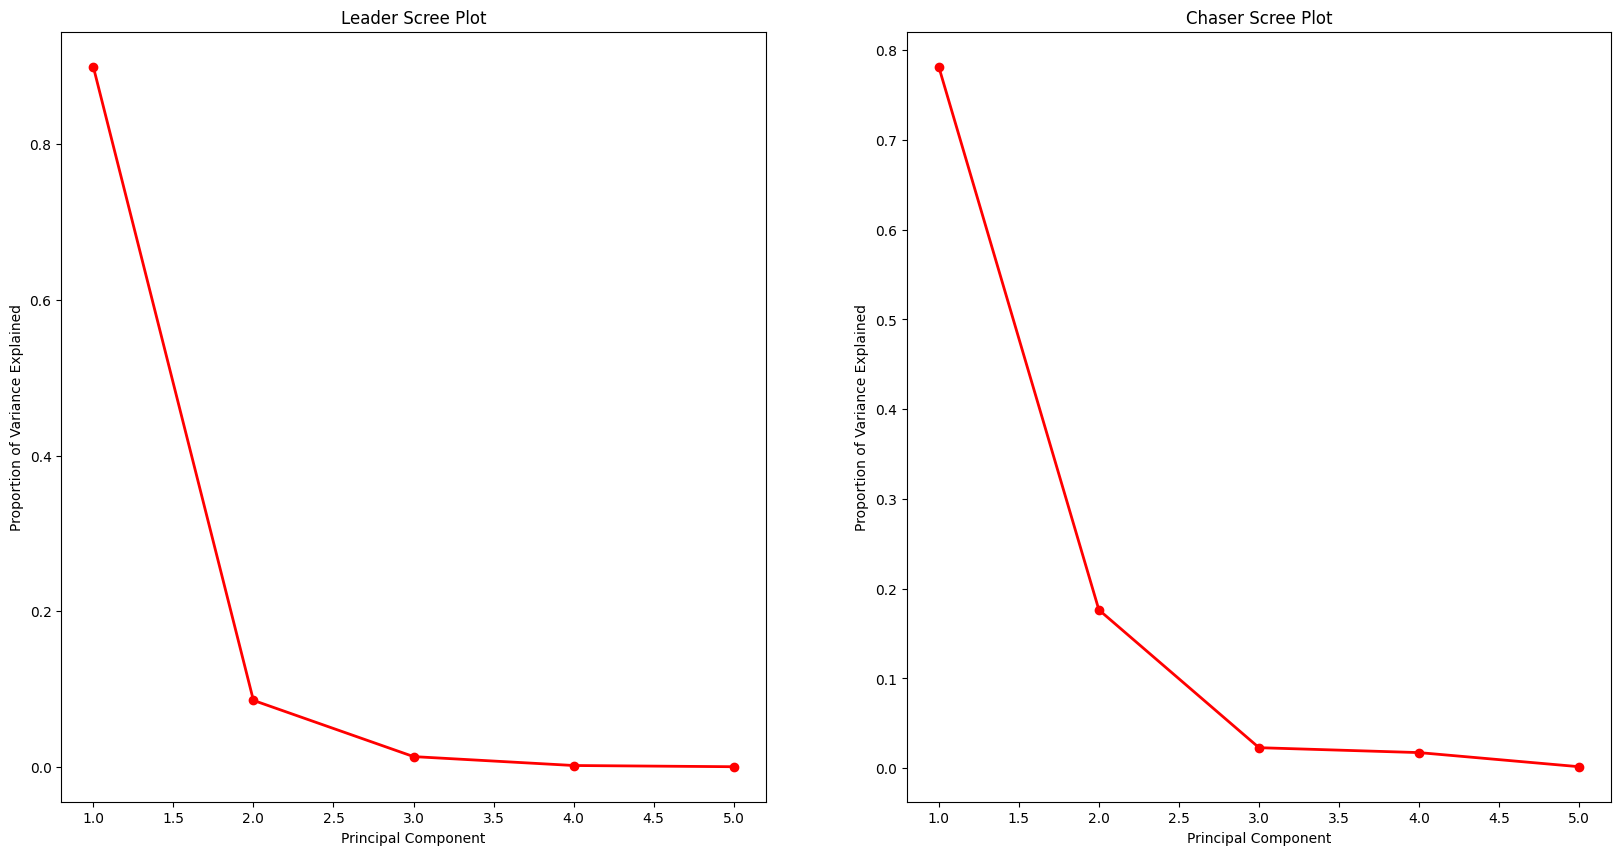

In [50]:
leader_pc_values = np.arange(pca_leader.n_components_) + 1
chaser_pc_values = np.arange(pca_chaser.n_components_) + 1

fig_scree_comp, (ax_scree_comp_lead, ax_scree_comp_chase) = plt.subplots(1, 2, figsize=(20, 10))

ax_scree_comp_lead.plot(leader_pc_values, pca_leader.explained_variance_ratio_, 'ro-', linewidth=2)
ax_scree_comp_lead.set_title('Leader Scree Plot')
ax_scree_comp_lead.set_xlabel('Principal Component')
ax_scree_comp_lead.set_ylabel('Proportion of Variance Explained')

ax_scree_comp_chase.plot(chaser_pc_values, pca_chaser.explained_variance_ratio_, 'ro-', linewidth=2)
ax_scree_comp_chase.set_title('Chaser Scree Plot')
ax_scree_comp_chase.set_xlabel('Principal Component')
ax_scree_comp_chase.set_ylabel('Proportion of Variance Explained')

plt.show()

From these scree plots, we can see that the first component explains a large amount of the variance in the dataset. In the leader data, the 'elbow' appears to be fairly clear at the second component, indicating that the first component is the only one that is really needed. This is backed up by the first components score of over 0.8 (or 80%). The chase data is less clear, with potential elbows a the second and third components. With the sharper change at the third, and the first component not quite reaching the required 80%, it is likely that the first two components are needed.

## Further steps and conclusions

This notebook has shown some of the statistical methods that can be used on metadata available from Discovery, with a starting look into grouping similar records, and plotting data to illustrate some variation. This notebook has only scratched the surface of statistics; the methods shown here are fairly commonly encountered, and the is more nuance to these methods than is shown here (a linear regression assumes that the relationship is a straight line, what if it is a curve?). Depending on the research question, there are a variety of other methods that could be used. As some examples, it is possible to: use statistics to describe a set of records as a whole; investigate whether individual records are spread evenly throughout the time period (or if they tend to cluster around the start date, for example); or use the information from the records to make predictions. This last point leads into the field of machine learning, which the case studies on Large Language Models (LLMs) introduce. 

With the variety of tests and methods available, the most useful next step from this notebook is to consider the context of your data and potential research questions. From there, you can research what statistical methods are most suited. Or, if this notebook has raised your interest in statistics more generally (for example, you may be interested in knowing how a PCA works in more depth), there are many resources and tutorials available online.